In [1]:
using OrdinaryDiffEq
using LinearAlgebra
using Distributions
using Random
using StatsBase
using Plots
using FiniteDiff
using Statistics
using NPZ
using DSP
#using MAT
using Dates
using DataStructures
using CSV, DataFrames, JSON

function print_current_time()
    println("Current time: ", Dates.format(now(), "HH:MM:SS"))
end

print_current_time (generic function with 1 method)

In [2]:
Random.seed!(2395)  # pick any integer you like

TaskLocalRNG()

In [54]:
include("dcm_final.jl")
include("vb_infer_final.jl")
include("group_inference_final.jl")


Main.GroupInference

In [38]:
using .VBInfer
using .GroupInference
using .DCMRealData
using LinearAlgebra
using Plots


# Using all embodiment blocks of session 1 

In [39]:
### FORMAT
# Y_subj = [y1, y2, ..., y5], each a (T, R) matrix of fMRI signals
# task_input = [0, 0, 1, 1, ..., 0]

parc = "Parc_Pers_z_det_dct"  # full: Parc8_2emb  2 sessions "Parc4_S_all-emb" 
                     # Parc4 for the 2 SC + 2 SM
                     # Parc4_ses1_2emb for for the 1 session only 2 embodiments 
                     # Parc4_ses1 has the full paradigm with all embodiments blocks

test = "ParcPerz_n10_dct" # USED:Parc4S_all-blocks_n10, Parc4_4blocks2ses_n10, Parc4_all-blocks_ses1_n10

                            # others Parc4_2blocks1ses_n5

y1 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-1.npy")';
y2 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-2.npy")';
y3 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-3.npy")';
y4 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-4.npy")';
y5 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-5.npy")';
y6 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-6.npy")';
y7 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-7.npy")';
y8 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-8.npy")';
y9 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-9.npy")';
y10 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/sub-10.npy")';


Y_subj = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10];

task1 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-1_task_vec.npy");
task2 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-2_task_vec.npy");
task3 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-3_task_vec.npy");
task4 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-4_task_vec.npy");
task5 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-5_task_vec.npy");
task6 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-6_task_vec.npy");
task7 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-7_task_vec.npy");
task8 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-8_task_vec.npy");
task9 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-9_task_vec.npy");
task10 = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/task/sub-10_task_vec.npy");

task_inputs = [task1, task2, task3, task4, task5, task6, task7, task8, task9, task10];  # each is a vector

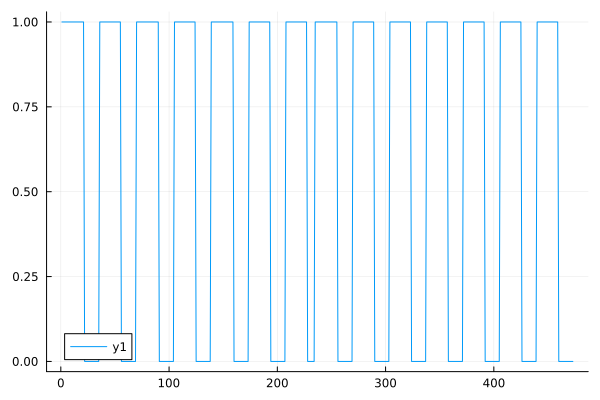

In [40]:
plot(task1)

In [41]:
function take_first2sess(vec::Vector{Float64})
    # Find where vec transitions from 0→1 (starts of 1s)
    starts = findall(diff(vec) .== 1) .+ 1  # Index where each block of 1s starts
    
    # Find the third start of 1s (i.e., after two complete 1-0 blocks)
    third_start = starts[2]  # Index where third 1-segment begins
    
    # Extract everything up to just before third 1-segment
    result = vec[1:third_start - 1]
    return result
   
end

take_first2sess (generic function with 1 method)

In [42]:
new_task_inputs = []
for t_ in task_inputs
    push!(new_task_inputs,take_first2sess(t_))
end


new_Y_subj = []
for (i, y) in enumerate(Y_subj)
    push!(new_Y_subj, y[(1:length(new_task_inputs[i])), :])
end

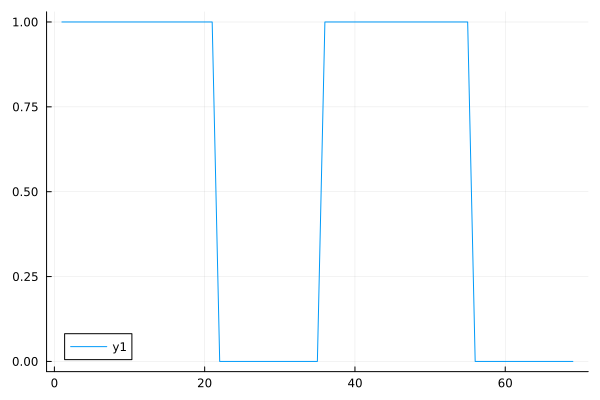

In [43]:
plot(new_task_inputs[1])

In [44]:
n = 4
n_subjects = length(Y_subj)
TR = 1.55

labels = [ "A$(i)$(j)" for i in 1:n, j in 1:n ] |> vec
append!(labels, [ "B$(i)$(j)" for i in 1:n, j in 1:n ] |> vec)
append!(labels, ["C$i" for i in 1:n])
append!(labels, ["tau$i" for i in 1:n])
append!(labels, ["alpha$i" for i in 1:n])

# labels = String[]
# append!(labels, ["A[$i,$j]" for i in 1:n, j in 1:n])
# append!(labels, ["B[$i,$j]" for i in 1:n, j in 1:n])
# append!(labels, ["C[$i]" for i in 1:n])
# append!(labels, ["τs[$i]" for i in 1:n])
# append!(labels, ["τf[$i]" for i in 1:n])
# append!(labels, ["τ0[$i]" for i in 1:n])
# append!(labels, ["E0[$i]" for i in 1:n])
# append!(labels, ["α[$i]" for i in 1:n])

44-element Vector{String}:
 "A11"
 "A21"
 "A31"
 "A41"
 "A12"
 "A22"
 "A32"
 "A42"
 "A13"
 "A23"
 "A33"
 "A43"
 "A14"
 ⋮
 "C1"
 "C2"
 "C3"
 "C4"
 "tau1"
 "tau2"
 "tau3"
 "tau4"
 "alpha1"
 "alpha2"
 "alpha3"
 "alpha4"

In [65]:
boost_prior = 3

# old model defs
# model_defs = OrderedDict(
#     :C1_only         => begin C = zeros(n); C[1] = 0.2+boost_prior; (C, zeros(n, n), -0.5I(n), false) end,
#     :C4_only         => begin C = zeros(n); C[4] = 0.2+boost_prior; (C, zeros(n, n), -0.5I(n), false) end,
#     :C1_B1to4        => begin C = zeros(n); C[1] = 0.2+boost_prior; B = zeros(n, n); B[4, 1] = 0.1+boost_prior; (C, B, -0.5I(n), true) end,
#     :C4_B4to1        => begin C = zeros(n); C[4] = 0.2+boost_prior; B = zeros(n, n); B[1, 4] = 0.1+boost_prior; (C, B, -0.5I(n), true) end,
#     :C14_Bbi         => begin C = zeros(n); C[1] = 0.2+boost_prior; C[4] = 0.2+boost_prior; B = zeros(n, n); B[1, 4] = 0.1+boost_prior; B[4, 1] = 0.1+boost_prior; (C, B, -0.5I(n), true) end,
#     :B1to4_only      => begin C = zeros(n); B = zeros(n, n); B[4, 1] = 0.1+boost_prior; (C, B, -0.5I(n), true) end,
#     :B4to1_only      => begin C = zeros(n); B = zeros(n, n); B[1, 4] = 0.1+boost_prior; (C, B, -0.5I(n), true) end,
#     :Null            => (zeros(n), zeros(n, n), -0.5I(n), false), # A only with no priors
#     :A14_only        => begin C = zeros(n); B = zeros(n, n); A = -0.5 * Matrix{Float64}(I(n)); A[4, 1] = 0.1 + boost_prior; (C, B, A, false) end,
#     :A41_only        => begin C = zeros(n); B = zeros(n, n); A = -0.5 * Matrix{Float64}(I(n)); A[1, 4] = 0.1 + boost_prior; (C, B, A, false) end,
#     :A14_B1to4_C1    => begin C = zeros(n); C[1] = 0.2+boost_prior; B = zeros(n, n); B[4, 1] = 0.1+boost_prior; A= -0.5 * Matrix{Float64}(I(n)); A[4, 1] = 0.1 + boost_prior; (C, B, A, true) end,
#     :A41_B4to1_C4    => begin C = zeros(n); C[4] = 0.2+boost_prior; B = zeros(n, n); B[1, 4] = 0.1+boost_prior; A= -0.5 * Matrix{Float64}(I(n)); A[1, 4] = 0.1 + boost_prior; (C, B, A, true) end
# )

3

# NEW (model def on B)

In [63]:
informed = false
A_to_use = -0.5 * Matrix{Float64}(I(n))
if informed
    A_to_use[1, 4] = 0.05  # R_DH → L_S1 (baseline ascending)
    A_to_use[4, 1] = 0.05  # L_S1 → R_DH (feedback)
    A_to_use[1, 2] = A_to_use[2, 1] = 0.05  # L_S1 ↔ R_S1
    A_to_use[3, 4] = A_to_use[4, 3] = 0.05  # L_DH ↔ R_DH
end
    
A_to_use

4×4 Matrix{Float64}:
 -0.5  -0.0  -0.0  -0.0
 -0.0  -0.5  -0.0  -0.0
 -0.0  -0.0  -0.5  -0.0
 -0.0  -0.0  -0.0  -0.5

In [66]:
model_defs = OrderedDict(

    # Null model: input to R_DH only, no modulation
    :C4_only_B0_null => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        (C, B, A, false)
    end,

    # Ascending modulation: R_DH → L_S1
    :C4_only_B41_ascend => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[1, 4] = 2 + boost_prior  # R_DH → L_S1
        (C, B, A, true)
    end,

    # Ascending and descending modulation: R_DH → L_S1 and L_S1 → R_DH
    :C4_only_B_ascdesc => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[1, 4] = 2 + boost_prior  # R_DH → L_S1
        B[4, 1] = 2 + boost_prior  # L_S1 → R_DH
        (C, B, A, true)
    end,

    # Spinal modulation bdir: R_DH <-> L_DH
    :C4_only_B_spinal => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[3, 4] = 1 + boost_prior  # R_DH → L_DH
        B[4, 3] = 1 + boost_prior  # L_DH → R_DH
        (C, B, A, true)
    end,

    # Cortical modulation: R_S1 -> L_S1
    :C4_only_B_cortical => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[1, 2] = 1 + boost_prior  # R_S1 → L_S1
        B[2, 1] = 1 + boost_prior  # L_S1 → R_S1
        (C, B, A, true)
    end,

    # Spinal modulation bdir: R_DH <-> L_DH
    :C4_only_B43_spinal => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[3, 4] = 1 + boost_prior  # R_DH → L_DH
        (C, B, A, true)
    end,

    # Cortical modulation: R_S1 <-> L_S1
    :C4_only_B21_cortical => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[2, 1] = 1 + boost_prior  # R_S1 → L_S1
        (C, B, A, true)
    end,

    # Full model: ascending, descending, cortical, and spinal modulations
    :C4_only_B_full => begin
        local C = zeros(n)
        C[4] = 2 + boost_prior
        local A = A_to_use
        local B = zeros(n, n)
        B[1, 4] = 1 + boost_prior  # R_DH → L_S1
        B[4, 1] = 1 + boost_prior  # L_S1 → R_DH
        B[1, 2] = B[2, 1] = 0.5 + boost_prior  # L_S1 ↔ R_S1
        B[3, 4] = B[4, 3] = 0.5 + boost_prior  # L_DH ↔ R_DH
        (C, B, A, true)
    end
)


OrderedDict{Symbol, Tuple{Vector{Float64}, Matrix{Float64}, Matrix{Float64}, Bool}} with 8 entries:
  :C4_only_B0_null      => ([0.0, 0.0, 0.0, 5.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0…
  :C4_only_B41_ascend   => ([0.0, 0.0, 0.0, 5.0], [0.0 0.0 0.0 5.0; 0.0 0.0 0.0…
  :C4_only_B_ascdesc    => ([0.0, 0.0, 0.0, 5.0], [0.0 0.0 0.0 5.0; 0.0 0.0 0.0…
  :C4_only_B_spinal     => ([0.0, 0.0, 0.0, 5.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0…
  :C4_only_B_cortical   => ([0.0, 0.0, 0.0, 5.0], [0.0 4.0 0.0 0.0; 4.0 0.0 0.0…
  :C4_only_B43_spinal   => ([0.0, 0.0, 0.0, 5.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0…
  :C4_only_B21_cortical => ([0.0, 0.0, 0.0, 5.0], [0.0 0.0 0.0 0.0; 4.0 0.0 0.0…
  :C4_only_B_full       => ([0.0, 0.0, 0.0, 5.0], [0.0 3.5 0.0 4.0; 3.5 0.0 0.0…

In [59]:
using MAT


In [60]:
path

path (generic function with 1 method)

In [67]:
function save_model_to_mat(name, C, B, A)
    mat_file = matopen("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/$parc/matlab/model/dcm_model_" * String(name) * ".mat", "w")
    write(mat_file, "C", C)
    write(mat_file, "B", B)
    write(mat_file, "A", A)
    close(mat_file)
end

save_model_to_mat (generic function with 1 method)

In [30]:
θ_estimates = Dict(model => [] for model in keys(model_defs))
θ_estimates_var = Dict(model => [] for model in keys(model_defs))
Σ_estimates = Dict(model => [] for model in keys(model_defs))
free_energies = Dict(model => [] for model in keys(model_defs))

Dict{Symbol, Vector{Any}} with 8 entries:
  :C4_only_B_cortical   => []
  :C4_only_B_ascdesc    => []
  :C4_only_B21_cortical => []
  :C4_only_B0_null      => []
  :C4_only_B_spinal     => []
  :C4_only_B43_spinal   => []
  :C4_only_B41_ascend   => []
  :C4_only_B_full       => []

In [31]:
model_names = collect(keys(model_defs))


8-element Vector{Symbol}:
 :C4_only_B0_null
 :C4_only_B41_ascend
 :C4_only_B_ascdesc
 :C4_only_B_spinal
 :C4_only_B_cortical
 :C4_only_B43_spinal
 :C4_only_B21_cortical
 :C4_only_B_full

In [49]:
function make_prior_var(A, B, C; use_B=true, high_var=0.1, low_var=1e-6, dyn_var=0.1)
    n = length(C)
    prior_var_A = [abs(a) > 1e-8 ? high_var : low_var for a in vec(A)]
    prior_var_B = use_B ? [abs(b) > 1e-8 ? high_var : low_var for b in vec(B)] : Float64[]
    prior_var_C = [abs(c) > 1e-8 ? high_var : low_var for c in C]
    prior_var_τ = fill(dyn_var, n)
    prior_var_α = fill(dyn_var, n)
    return vcat(prior_var_A, prior_var_B, prior_var_C, prior_var_τ, prior_var_α)
end

make_prior_var (generic function with 1 method)

In [50]:
TR

1.55

In [68]:
n_repeats = 1 #10

for i in 1:n_subjects
    @show i
    y_obs = Y_subj[i]         #new_Y_subj[i] #Y_subj[i]
    task = task_inputs[i]     #new_task_inputs[i] #task_inputs[i]
    T = size(y_obs, 1)
    tvec = collect(0:TR:(T-1)*TR)
    u_func = DCMRealData.make_input_function(task, tvec)
    predict_func = (params, t) -> DCMRealData.simulate_dcm(params, tvec)


    for (model, (C, B, A, use_B)) in model_defs
        @show model
        # init list of subject-estimates per iteration
        θs = Float64[] 
        Fs = Float64[]  
        for r in 1:n_repeats
            @show r
            θ0 = VBInfer.create_theta0(n, C, B, A; use_B=use_B)
            prior_var = make_prior_var(A, B, C; use_B=use_B)
            θ, F = VBInfer.vb_infer(θ0, y_obs, tvec, n, u_func, use_B; predict_func=predict_func,prior_var=prior_var)
            append!(θs, θ)
            push!(Fs, F)
        end
        
        #θ0 = VBInfer.create_theta0(n, C, B)
        #θ, F = VBInfer.vb_infer(θ0, y_obs, tvec, n, u_func, use_B; predict_func=predict_func)
        
        θ_mat = reshape(θs, :, n_repeats)'  # shape (n_repeats, n_params)
        θ_avg = mean(θ_mat, dims=1)[:]      # mean θ across repeats
        F_avg = mean(Fs)                    # mean free energy
        θ_var = var(θ_mat, dims=1)[:]
        
        # push!(θ_estimates[model], θ)
        # push!(free_energies[model], F)
        push!(θ_estimates[model], θ_avg)
        push!(θ_estimates_var[model], θ_var)
        push!(free_energies[model], F_avg)
        
    end
end

i = 1
model = :C4_only_B0_null
r = 1
model = :C4_only_B41_ascend
r = 1
model = :C4_only_B_ascdesc
r = 1
model = :C4_only_B_spinal
r = 1
model = :C4_only_B_cortical
r = 1
model = :C4_only_B43_spinal
r = 1
model = :C4_only_B21_cortical
r = 1
model = :C4_only_B_full
r = 1
i = 2
model = :C4_only_B0_null
r = 1
model = :C4_only_B41_ascend
r = 1
model = :C4_only_B_ascdesc
r = 1
model = :C4_only_B_spinal
r = 1
model = :C4_only_B_cortical
r = 1
model = :C4_only_B43_spinal
r = 1
model = :C4_only_B21_cortical
r = 1
model = :C4_only_B_full
r = 1
i = 3
model = :C4_only_B0_null
r = 1
model = :C4_only_B41_ascend
r = 1
model = :C4_only_B_ascdesc
r = 1
model = :C4_only_B_spinal
r = 1
model = :C4_only_B_cortical
r = 1
model = :C4_only_B43_spinal
r = 1
model = :C4_only_B21_cortical
r = 1
model = :C4_only_B_full
r = 1
i = 4
model = :C4_only_B0_null
r = 1
model = :C4_only_B41_ascend
r = 1
model = :C4_only_B_ascdesc
r = 1
model = :C4_only_B_spinal
r = 1
model = :C4_only_B_cortical
r = 1
model = :C4_only_B43

In [56]:
θ_estimates

Dict{Symbol, Vector{Any}} with 8 entries:
  :C4_only_B_cortical   => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B_ascdesc    => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B21_cortical => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B0_null      => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B_spinal     => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B43_spinal   => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B41_ascend   => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …
  :C4_only_B_full       => [[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …

In [57]:
for model in keys(θ_estimates)
    println("Model: ", model)
    for (i, θ) in enumerate(θ_estimates[model])
        A, B, C, τs, τf, τ0, E0, α = VBInfer.unpack_params(θ, n, occursin("B", String(model)))
        println(C)
    end
end


Model: C4_only_B_cortical


LoadError: BoundsError: attempt to access Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}} at index [6]

In [270]:
T = size(Y_subj[1], 1)
tvec = collect(0:TR:(T-1)*TR)
u_func = DCMRealData.make_input_function(task_inputs[1], tvec)

params = (A=zeros(n,n), B=zeros(n,n), C=zeros(n), τs=ones(n), τf=ones(n)*2, τ0=ones(n), 
          E0=fill(0.34, n), α=fill(0.33, n), e₀=fill(0.34, n), n_regions=n, u=u_func)
y_sim = DCMRealData.simulate_dcm(params, tvec)
@show maximum(abs, y_sim), minimum(y_sim)

(maximum(abs, y_sim), minimum(y_sim)) = (1.0, -1.0)


┌ Warning: dt(1.1368683772161603e-13) <= dtmin(1.1368683772161603e-13) at t=0.0, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/iricchi/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:599


(1.0, -1.0)

In [131]:
u_func(tvec)

LoadError: MethodError: no method matching isless(::Float64, ::Vector{Float64})
[0mClosest candidates are:
[0m  isless(::T, [91m::T[39m) where T<:Union{Float16, Float32, Float64} at ~/bin/julia-1.7.2/share/julia/base/float.jl:460
[0m  isless([91m::AbstractVector[39m, ::AbstractVector) at ~/bin/julia-1.7.2/share/julia/base/abstractarray.jl:2532
[0m  isless(::Real, [91m::Static.StaticInteger{Y}[39m) where Y at ~/.julia/packages/Static/IYKUj/src/Static.jl:466
[0m  ...

In [ ]:
## PLOT POSTERIORS
for model in keys(θ_estimates)
    println("Model: ", model)
    for (i, θ) in enumerate(θ_estimates[model])
        Σ = Σ_estimates[model][i]
        A, B, C, τs, τf, τ0, E0, α = VBInfer.unpack_params(θ, n, occursin("B", String(model)))

        # Compute A variances
        Σ_diag = diag(Σ)
        offset = 0
        A_var = reshape(Σ_diag[offset+1 : offset+n^2], n, n)

        heatmap(A_var, title="Subject $i - A variance ($model)", xlabel="To", ylabel="From", 
                c=:viridis, size=(300,300), yflip=true)
        display(current())
    end
end

In [ ]:
# Posterior probabilities
posterior_probs = GroupInference.compare_models(free_energies)
println("Posterior model probabilities (rows=subjects, cols=models):\n", posterior_probs)


In [ ]:
heatmap(posterior_probs', xlabel="Subjects", ylabel="Models", c=:balance, size=(300,300), yflip=true)

In [ ]:
### THIS IS MORE AT THE GROUP LEVEL POSTERIOR

#Sum of log model evidences across subjects
model_names = collect(keys(free_energies))
log_model_evidence = [sum(free_energies[m]) for m in model_names]

# Convert to probabilities
logZ = log_model_evidence .- maximum(log_model_evidence)
group_posteriors = exp.(logZ)
group_posteriors ./= sum(group_posteriors)

println("Group posterior model probabilities:\n", group_posteriors)

In [ ]:
avg_posteriors = mean(posterior_probs, dims=1)
best_model_index = argmax(avg_posteriors)

In [ ]:
println("BEST MODEL (max posterior prob): ", model_names[best_model_index[2]])

In [ ]:
# Summary: model selection per subject
for i in 1:n_subjects
    best_idx = argmax(posterior_probs[i, :])
    println("Subject $i best model: ", model_names[best_idx])
end

## Bayesian Model Averaging per subject

In [23]:
function run_full_bma(
    θ_estimates::Dict{Symbol, Vector{Vector{Float64}}},
    Σ_estimates::Dict{Symbol, Vector{Matrix{Float64}}},
    posterior_probs::Matrix{Float64};
    model_names::Vector{Symbol}=collect(keys(θ_estimates)),
    prob_thresh::Float64=0.05
)
    n_subjects = size(posterior_probs, 1)
    θ_dim = length(θ_estimates[model_names[1]][1])
    θ_bma = Vector{Vector{Float64}}(undef, n_subjects)
    Σ_bma = Vector{Matrix{Float64}}(undef, n_subjects)

    for s in 1:n_subjects
        θ_sum = zeros(θ_dim)
        Σ_sum = zeros(θ_dim, θ_dim)
        norm_const = 0.0

        for (m, model) in enumerate(model_names)
            p = posterior_probs[s, m]
            if p < prob_thresh
                continue  # skip low-probability models
            end

            θ_m = θ_estimates[model][s]
            Σ_m = Σ_estimates[model][s]

            θ_sum .+= p .* θ_m
            Σ_sum .+= p .* (Σ_m .+ θ_m * θ_m')
            norm_const += p
        end

        # Normalize and compute final posterior mean + covariance
        μ_bma = θ_sum ./ norm_const
        Σ_bma[s] = (Σ_sum ./ norm_const) .- (μ_bma * μ_bma')  # Cov(θ) = E[Σ + θθᵀ] - μμᵀ
        θ_bma[s] = μ_bma
    end

    return θ_bma, Σ_bma
end


run_full_bma (generic function with 1 method)

In [ ]:
θ_bma, Σ_bma = run_full_bma(θ_estimates, Σ_estimates, posterior_probs;
                            model_names=model_names, prob_thresh=0.05)


In [ ]:
# GROUP AVERAGING
θ_bma_mat = reduce(vcat, θ_bma)'
θ_bma_group_avg = mean(θ_bma_mat, dims=1)

In [24]:
function plot_bma_matrix(
    θ_bma::Vector{Vector{Float64}}, 
    n::Int, 
    matrix_type::Symbol = :A;  # or :B
    use_B::Bool = true
)
    for (i, θ) in enumerate(θ_bma)
        A, B, C, τs, τf, τ0, E0, α = VBInfer.unpack_params(θ, n, use_B)
        mat = matrix_type == :A ? A : B
        heatmap(Float64.(mat), title="Subject $i - BMA $(Symbol(matrix_type)) matrix", 
                xlabel="To", ylabel="From", c=:balance, yflip=true, size=(350, 350))
        display(current())
    end
end

plot_bma_matrix (generic function with 2 methods)

In [ ]:
function plot_bma_hrf_summary(θ_bma::Vector{Vector{Float64}}, n::Int; use_B::Bool=true)
    τs_all = []
    α_all = []
    for θ in θ_bma
        _, _, _, τs, _, _, _, α = VBInfer.unpack_params(θ, n, use_B)
        append!(τs_all, τs)
        append!(α_all, α)
    end
    group_labels = vcat(["τs"] .* (1:n), ["α"] .* (1:n))
    values = vcat(τs_all, α_all)

    boxplot(group_labels, values, xlabel="Region & Param", ylabel="Estimate", 
            title="HRF Param Distribution (BMA)", legend=false, rotate_xticks=45)
end


In [ ]:
function plot_c_bma_vs_model(
    θ_bma::Vector{Vector{Float64}}, 
    θ_best::Vector{Vector{Float64}}, 
    n::Int, 
    subject::Int; 
    use_B::Bool=true
)
    _, _, C_bma, _, _, _, _, _ = VBInfer.unpack_params(θ_bma[subject], n, use_B)
    _, _, C_best, _, _, _, _, _ = VBInfer.unpack_params(θ_best[subject], n, use_B)

    bar(["Region $i" for i in 1:n], [C_bma C_best], 
        label=["BMA" "Best Model"], title="Subject $subject - C vector", 
        ylabel="Effective Input Strength", legend=:topleft)
end


In [ ]:
plot_bma_matrix(θ_bma, n, :B)                     # Plot B matrices


In [ ]:
plot_bma_hrf_summary(θ_bma, n)                    # Boxplot of τs and α


In [ ]:
plot_c_bma_vs_model(θ_bma, θ_estimates[:best_model], n, 1)  # Compare C for subject 1


### BMA on only B

In [25]:
function bma_B_only(
    θ_estimates::Dict{Symbol, Vector{Vector{Float64}}},
    posterior_probs::Matrix{Float64},
    n::Int;
    model_names=collect(keys(θ_estimates)),
    prob_thresh=0.05,
    use_B=true
)
    n_subjects = size(posterior_probs, 1)
    bma_Bs = Vector{Matrix{Float64}}(undef, n_subjects)

    for s in 1:n_subjects
        B_sum = zeros(n, n)
        norm_const = 0.0

        for (m, model) in enumerate(model_names)
            p = posterior_probs[s, m]
            if p < prob_thresh
                continue
            end
            θ = θ_estimates[model][s]
            _, B, _, _, _, _, _, _ = VBInfer.unpack_params(θ, n, use_B)
            B_sum .+= p .* B
            norm_const += p
        end

        bma_Bs[s] = B_sum ./ norm_const
    end

    return bma_Bs
end


bma_B_only (generic function with 1 method)

In [ ]:
bma_Bs = bma_B_only(θ_estimates, posterior_probs, n)


In [ ]:
B_group_avg = mean(reduce(hcat, [vec(B) for B in bma_Bs]), dims=2)
B_group_avg_mat = reshape(B_group_avg, n, n)
heatmap(B_group_avg_mat, title="Group BMA: B matrix", yflip=true)

# PEB - BMR

In [ ]:
model_name = :C4_only_B5_full  # or best model
θs = θ_estimates[model_name]         # Vector of θ (MAP) per subject
Σs = Σ_estimates[model_name]         # Vector of Σ (covariance) per subject


In [ ]:
μ_peb, Σ_peb = run_peb(θs, Σs)


In [ ]:
active_mask = run_bmr_greedy(μ_peb, σ²_peb, labels; max_steps=15, λ=1e-2)


In [ ]:
println("Retained parameters (BMR):")
for (i, keep) in enumerate(active_mask)
    if keep
        println("✓ ", labels[i])
    end
end

In [ ]:
retain_freq = bmr_stability_analysis(μ_peb, σ²_peb, labels; n_runs=30, max_steps=10)
bar(labels, retain_freq, title="BMR Stability", xticks=labels, legend=false, rotate=45)


## PEB Only  on B

In [ ]:
b_indices = findall(label -> startswith(label, "B["), labels)


In [ ]:
# Subset B only
μ_B = μ[b_indices]
σ²_B = σ²[b_indices]
labels_B = labels[b_indices]

# Run BMR on B only
active_B_mask = GroupInference.run_bmr_greedy(μ_B, σ²_B, labels_B; max_steps=10)


In [ ]:
println("Retained parameters (BMR):")
for (i, keep) in enumerate(active_B_mask)
    if keep
        println("✓ ", labels_B[i])
    end
end

In [ ]:
retain_freq = bmr_stability_analysis(μ_B, σ²_B, labels_B; n_runs=30, max_steps=10)
bar(labels, retain_freq, title="BMR Stability", xticks=labels, legend=false, rotate=45)


In [ ]:
function plot_group_means(μ::Vector{Float64}, σ²::Vector{Float64}, labels::Vector{String})
    se = sqrt.(σ²)

    bar(labels, μ, yerr=se, legend=false,
    title="Group-Level Parameter Estimates",
    xlabel="Parameter", ylabel="Value",
    xticks=(1:length(labels), labels),  # ✅ CORRECT form
    rotation=45, size=(1000, 400))

    # bar(labels, μ, yerr=se, legend=false, title="Group-Level Parameter Estimates",
    #     xlabel="Parameter", ylabel="Value", xticks=labels, rotation=45, size=(1000, 400))
end

function plot_matrix_heatmap(mat::Matrix{Float64}, title_str::String)
heatmap(
    mat,
    c=:balance,
    clim=(-0.1,0.1),
    title=title_str,
    xlabel="From",
    ylabel="To",
    size=(400, 400),
    yflip=true       # ✅ this makes row 1 appear on top
)
end
fir

## HRF

In [26]:
function simulate_hrf_shape(τs, τf, τ0, α, E0; T=32.0, dt=0.1)
    n_timepoints = Int(floor(T / dt)) + 1
    tvec = collect(0:dt:T)

    # impulse input
    z = zeros(n_timepoints)
    z[2] = 1.0  # short neural event

    # Initialize states
    s, f, v, q = 0.0, 1.0, 1.0, 1.0
    V0 = 0.02
    k1 = 7 * E0
    k2 = 2
    k3 = 2 * E0 - 0.2

    y_bold = zeros(n_timepoints)

    for i in 1:n_timepoints
        sn = z[i]
        ds = sn - τs * s - τf * (f - 1)
        df = s
        dv = (f - v^(1/α)) / τ0
        dq = (f * (1 - (1 - E0)^(1 / f)) / E0 - q * v^(1/α - 1)) / τ0

        s += dt * ds
        f += dt * df
        v += dt * dv
        q += dt * dq

        y_bold[i] = V0 * (k1 * (1 - q) + k2 * (1 - q / v) + k3 * (1 - v))
    end

    return tvec, y_bold
end


simulate_hrf_shape (generic function with 1 method)

In [ ]:
μ = μ_peb # μ_B
n = 4  # number of ROIs
n_A = n^2
n_B = n^2
n_C = n
n_HRF = length(μ) - (n_A + n_B + n_C)  # remaining = HRF parameters

HRF_vec = μ[end - n_HRF + 1 : end]

In [ ]:
HRF_vec
# Assume: HRF_vec = μ[end - n_HRF + 1:end]  # from run_peb
n_rois = 4
hrf_params = reshape(HRF_vec, 5, n_rois)  # [τs; τf; τ0; α; E0] per ROI


In [ ]:
p = plot(title = "Estimated HRFs by Region", xlabel = "Time (s)", ylabel = "BOLD Signal")

for roi in 1:n_regions
    τs, τf, τ0, α, E0 = hrf_params[:, roi]
    tvec, hrf_shape = simulate_hrf_shape(τs, τf, τ0, α, E0)
    plot!(p, tvec, hrf_shape, label = "ROI $roi")
end

display(p)

## Simulate 

In [ ]:
after_bms = false

if after_bms:
    # After BMS
    subject_i = 1
    θ_map = θ_bma[subject_i]
else:
    # After BMR 
    θ_map = μ_peb ## μ_B





In [ ]:
y_obs = npzread("/media/RCPNAS/Data3/Ilaria/TS_data/brain_spine_E_dcm/Parc4_S_all-emb/ses2/sub-1.npy")
task = task_inputs[1]
T = size(y_obs, 2)
tvec = collect(0:TR:(T-1)*TR)
u_func = DCMRealData.make_input_function(task, tvec)

In [ ]:
# Unpack parameters from θ_map
A, B, C, τ, α, τs, τf, τ0, E0 = VBInfer.unpack_params(θ_map, n, use_B)

# Prepare params struct for simulate_dcm
params = (
    A = A,
    B = B,
    C = C,
    τ = τ,
    α = α,
    τs = τs,
    τf = τf,
    τ0 = τ0,
    E0 = E0,
    e₀ = fill(0.34, n),
    n_regions = n,
    u = u_func
)

In [111]:
y_sim = DCMRealData.simulate_dcm(params, tvec)


10×8 Matrix{Float64}:
 0.813955      2.26805e-153  5.49405e-73   …  0.186045      5.03408e-29
 1.82614e-156  1.86265e-113  2.32195e-31      1.50701e-31   6.56577e-199
 1.61964e-34   1.0           1.20991e-231     1.36732e-166  1.07156e-145
 1.43197e-170  2.68229e-119  1.0              9.0277e-133   2.90488e-65
 9.3104e-231   2.21856e-239  1.95156e-69      1.0           0.0
 4.59584e-36   4.31013e-192  1.05671e-131  …  1.6915e-46    2.59241e-194
 2.93866e-17   4.2545e-61    4.00241e-55      4.92599e-26   1.78578e-60
 1.96074e-61   2.43165e-184  1.0              1.07037e-91   2.82302e-25
 1.32336e-74   7.08575e-58   9.97333e-58      3.86486e-59   1.91312e-151
 1.74186e-280  1.0           1.08933e-219     1.78429e-259  3.39288e-53

In [ ]:
plot(tvec, y_sim, xlabel="Time (s)", ylabel="Simulated BOLD", label=["ROI $i" for i in 1:n])

In [ ]:
plot(tvec, y_obs, label=["Observed ROI $i" for i in 1:n], linestyle=:dot, color=:gray)
plot!(tvec, y_sim, label=["Simulated ROI $i" for i in 1:n])
plot!(task)

# Priors-posterios

In [83]:
A_prior_mean = -0.5I(n)  # enforc

4×4 Diagonal{Float64, Vector{Float64}}:
 -0.5    ⋅     ⋅     ⋅ 
   ⋅   -0.5    ⋅     ⋅ 
   ⋅     ⋅   -0.5    ⋅ 
   ⋅     ⋅     ⋅   -0.5

In [84]:
params = θ_estimates[model_names[best_model_index[2]]]
subset = getindex.(params, Ref(1:16))  # returns a vector of 10 vectors of length 16
subset_mat = hcat(subset...)  # dimensions: 16 × 10
A_post_mean = mean(subset_mat,dims=2)
A_post_var = var(subset_mat,dims=2)

16×1 Matrix{Float64}:
 0.00011632803936393587
 5.180262225450509e-5
 3.131676853857842e-5
 0.0002121888592370314
 0.00018803900395910803
 0.031036557448700004
 0.00011869783084247166
 7.196648986730004e-5
 0.00021146677067814668
 7.136429732012007e-5
 2.7227179989775802e-5
 0.0002548881621735986
 3.647408852060115e-5
 0.010424866410298744
 0.00010664000179167757
 0.006527665693567547

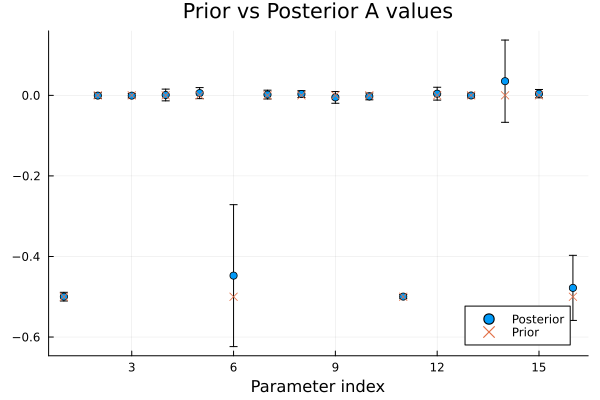

In [85]:
x = 1:(n*n)
plot(x, vec(A_post_mean), yerror=sqrt.(vec(A_post_var)), label="Posterior", seriestype=:scatter)
plot!(x, vec(A_prior_mean), label="Prior", seriestype=:scatter, marker=:x)
title!("Prior vs Posterior A values")
xlabel!("Parameter index")